# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# define the seed for randomized algorithms
seed = 42

# Define the features
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# define X and Y
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

In [4]:
# Do the split in test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (361, 12)
Test set shape: (156, 12)


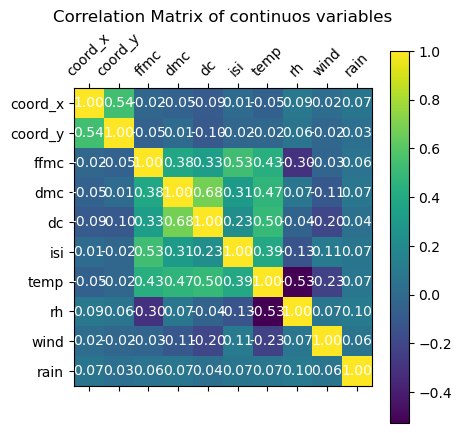

In [5]:
# Just a little of E.D.A
correlation_matrix = pd.DataFrame(fires_dt[numeric_features]).corr()
correlation_matrix

plt.matshow(correlation_matrix, cmap='viridis', fignum=1)
plt.colorbar()

plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)

# Display the correlation values inside the cells
for (i, j), val in np.ndenumerate(correlation_matrix.values):
    plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')

# Add a title and labels
plt.title("Correlation Matrix of continuos variables")

# Show the heatmap
plt.show()

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [6]:
# Preprocessing numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())  # Standard scaling
])

# Preprocessing categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

preproc1 = ColumnTransformer(
    transformers=[
        ('numerical_transformation', numeric_transformer, numeric_features),
        ('categorical_transformation', categorical_transformer, categorical_features)
    ]
)

preproc1 

ColumnTransformer(transformers=[('numerical_transformation',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('categorical_transformation',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [7]:
skewed_numeric_features = ['ffmc', 'rain', 'dmc', 'dc', 'isi', 'rh', 'wind']
regular_numeric_features = ['coord_x', 'coord_y', 'temp']

# Preprocessing numeric data
non_linear_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('log_transformation', FunctionTransformer(np.log1p, validate=True)), # Log transformation to ensure smoothness of the data
    ('scaler', RobustScaler()),  # Standard scaling
    # ('polynomial_transformation', PolynomialFeatures(degree=2, include_bias=False)) # Find complex interactions
])

preproc2 = ColumnTransformer(
    transformers=[
        ('numerical_transformation', numeric_transformer, regular_numeric_features),
        ('non_linear_numerical_transformation', non_linear_numeric_transformer, skewed_numeric_features),
        ('categorical_transformation', categorical_transformer, categorical_features)
    ]
)

preproc2

ColumnTransformer(transformers=[('numerical_transformation',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'temp']),
                                ('non_linear_numerical_transformation',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('log_transformation',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['ffmc', 'rain', 'dmc', 'dc', 'isi', 'rh',
                                  'wind']),
                                ('categorical_transformation',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [8]:
# Pipeline A = preproc1 + baseline
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', KNeighborsRegressor())
])

pipeline_A

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [9]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', KNeighborsRegressor())
])

pipeline_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y',
                                                   'temp']),
                                                 ('non_linear_numerical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['ffmc', 'rain', 'dmc', 'dc',
                                                   'isi', 'rh', 'wind']),
                                                 ('categorical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [10]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())
])

pipeline_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [11]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())
])

pipeline_D

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y',
                                                   'temp']),
                                                 ('non_linear_numerical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['ffmc', 'rain', 'dmc', 'dc',
                                                   'isi', 'rh', 'wind']),
                                                 ('categorical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [12]:
scoring_metric='neg_mean_squared_error'
k_folds=5
pipelines=[pipeline_A, pipeline_B, pipeline_C, pipeline_D]
pipeline_names=['pipeline_A', 'pipeline_B', 'pipeline_C', 'pipeline_D']
grid_result={}

# Define parameter grids
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 3],
    'regressor__max_features': ['log2', 'sqrt']
}

for pipeline, pipeline_name in zip(pipelines, pipeline_names):
    grid = GridSearchCV(pipeline, 
                        param_grid=param_grid_rf if isinstance(pipeline.named_steps['regressor'], RandomForestRegressor) else param_grid_knn,
                        cv=k_folds, 
                        scoring=scoring_metric)
    
    grid.fit(X_train, Y_train)
    grid_result[pipeline_name] = grid
    grid.best_estimator_
    print(f"Results for {pipeline_name} -> Best score: {-grid.best_score_} | Best params: {grid.best_params_}")

Results for pipeline_A -> Best score: 2734.554999754837 | Best params: {'regressor__algorithm': 'kd_tree', 'regressor__n_neighbors': 7, 'regressor__weights': 'uniform'}
Results for pipeline_B -> Best score: 2702.072421772513 | Best params: {'regressor__algorithm': 'ball_tree', 'regressor__n_neighbors': 7, 'regressor__weights': 'uniform'}


invalid value encountered in cast


Results for pipeline_C -> Best score: 2427.951295602787 | Best params: {'regressor__max_depth': 10, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Results for pipeline_D -> Best score: 2432.8575080924834 | Best params: {'regressor__max_depth': 10, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


# Evaluate

+ Which model has the best performance?

[52.292972756909094, 51.981462289671235, 49.27424576391593, 49.32400539384939]

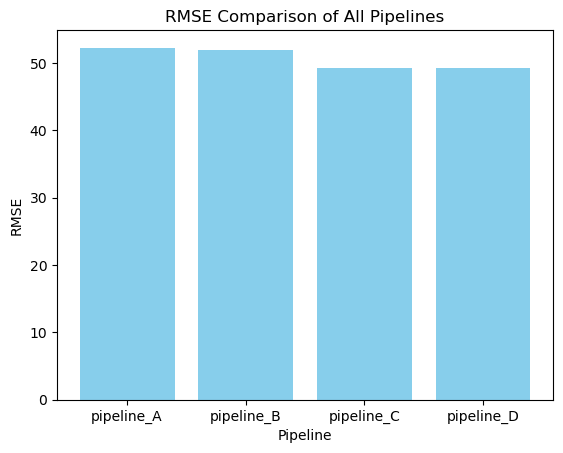

In [13]:
rmse_scores=[]

for pipeline in pipeline_names:
    # RMSE scores
    rmse_scores.append(np.sqrt(-grid_result[pipeline].best_score_))

display(rmse_scores)

# Plotting the RMSE scores
plt.bar(pipeline_names, rmse_scores, color='skyblue')
plt.xlabel('Pipeline')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of All Pipelines')
plt.show()

In [14]:
# Find best model based on RMSE
best_pipeline = min(grid_result, key=lambda x: np.sqrt(-grid_result[x].best_score_))
print(f"The best performing pipeline is {best_pipeline} and the best parameters are: {grid_result[best_pipeline].best_params_}")

The best performing pipeline is pipeline_C and the best parameters are: {'regressor__max_depth': 10, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


# Export

+ Save the best performing model to a pickle file.

In [15]:
best_estimator = grid_result[best_pipeline].best_estimator_ # Just making sure it does exist and is fitted :)
best_estimator

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical_transformation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, max_features='log2',
                                       min_samples_leaf=3,
                                       min_samples_split=5))])

In [16]:
# Export the best estimator
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_estimator, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [17]:
# transform the test data
X_test_transformed = best_estimator.named_steps['preprocessing'].transform(X_test)
X_train_transformed = best_estimator.named_steps['preprocessing'].transform(X_train)

# get the feature names
if ('non_linear_numerical_transformation' in best_estimator.named_steps['preprocessing'].named_transformers_): # is this preproc2?
    feature_names = np.concatenate([
        best_estimator.named_steps['preprocessing'].named_transformers_['numerical_transformation'].get_feature_names_out(), # Regular numeric features
        skewed_numeric_features, # Non-linear numeric features
        best_estimator.named_steps['preprocessing'].named_transformers_['categorical_transformation'].get_feature_names_out() # One-hot encoded categorical features
    ])
else: # or is this preproc1?
    feature_names = best_estimator.named_steps['preprocessing'].get_feature_names_out()

# Convert the scaled features back into a DataFrame to retain feature names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

print("Shape of transformed data:", X_test_transformed.shape)

Shape of transformed data: (156, 29)


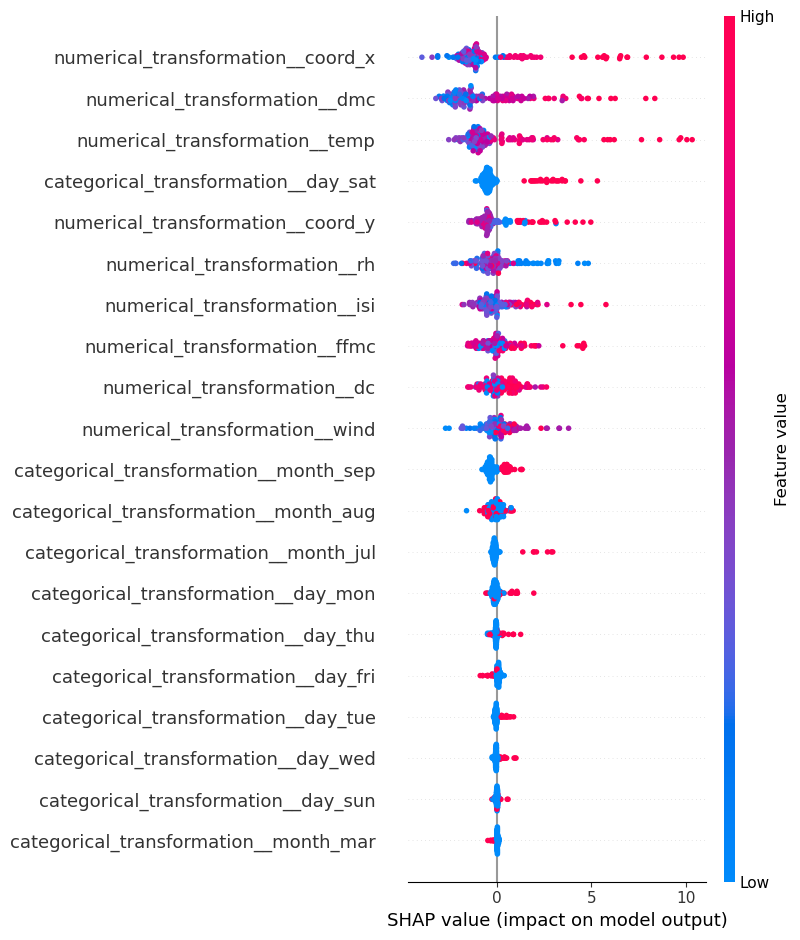

In [18]:

# Now after transforming the test data then we're builiding a SHAP analysis to explain the best model
if isinstance(best_estimator.named_steps['regressor'], RandomForestRegressor): # In case this is a Random Forest Regressor
    explainer = shap.TreeExplainer(best_estimator.named_steps['regressor'])
else:
    explainer = shap.KernelExplainer(best_estimator.named_steps['regressor'].predict, X_train_transformed_df)

shap_values = explainer.shap_values(X_test_transformed_df)

# Plot global feature importance
shap.summary_plot(shap_values, X_test_transformed_df)

In [19]:
# Local Explanation of a Specific Prediction
observation_loc = round(X_test_transformed_df.shape[0]/2) # grab a random observation index (in the middle)

observation_original_df = X_test.iloc[[observation_loc]]
observation_transformed_df = X_test_transformed_df.iloc[[observation_loc]]

display(observation_original_df)
display(observation_transformed_df)

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
431,1,3,aug,sat,92.1,178.0,605.3,9.6,23.3,40,4.0,0.0


,numerical_transformation__coord_x,numerical_transformation__coord_y,numerical_transformation__ffmc,numerical_transformation__dmc,numerical_transformation__dc,numerical_transformation__isi,numerical_transformation__temp,numerical_transformation__rh,numerical_transformation__wind,numerical_transformation__rain,...,categorical_transformation__month_nov,categorical_transformation__month_oct,categorical_transformation__month_sep,categorical_transformation__day_fri,categorical_transformation__day_mon,categorical_transformation__day_sat,categorical_transformation__day_sun,categorical_transformation__day_thu,categorical_transformation__day_tue,categorical_transformation__day_wed
78,-1.632057,-1.115595,0.261525,0.999041,0.237146,0.217579,0.770379,-0.28694,0.018683,-0.070974,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


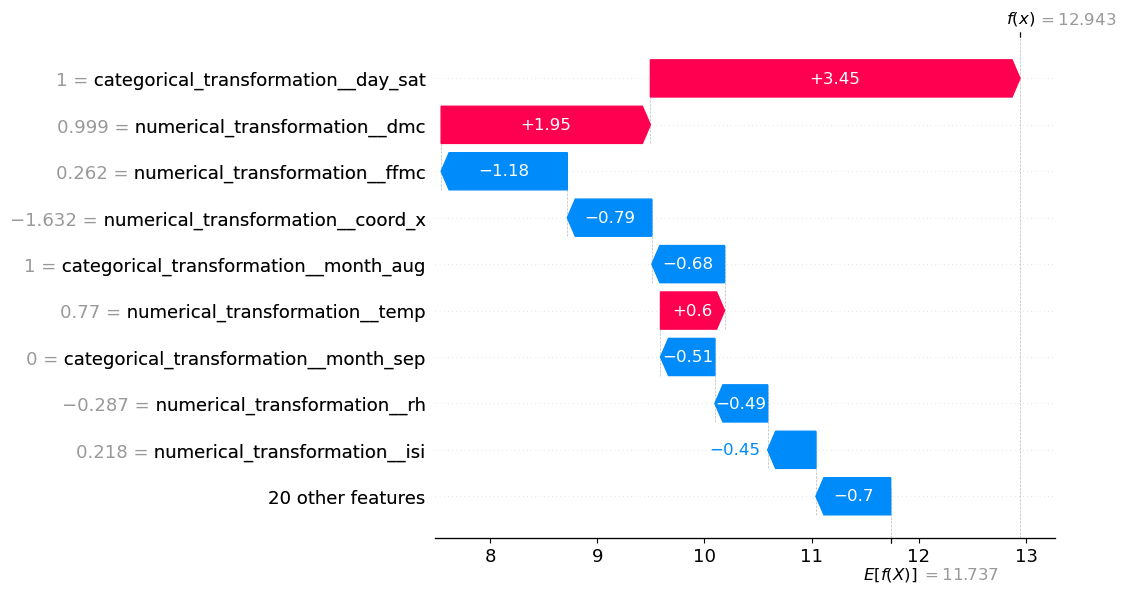

In [20]:
explanation = explainer(X_test_transformed_df)
shap.plots.waterfall(explanation[observation_loc])

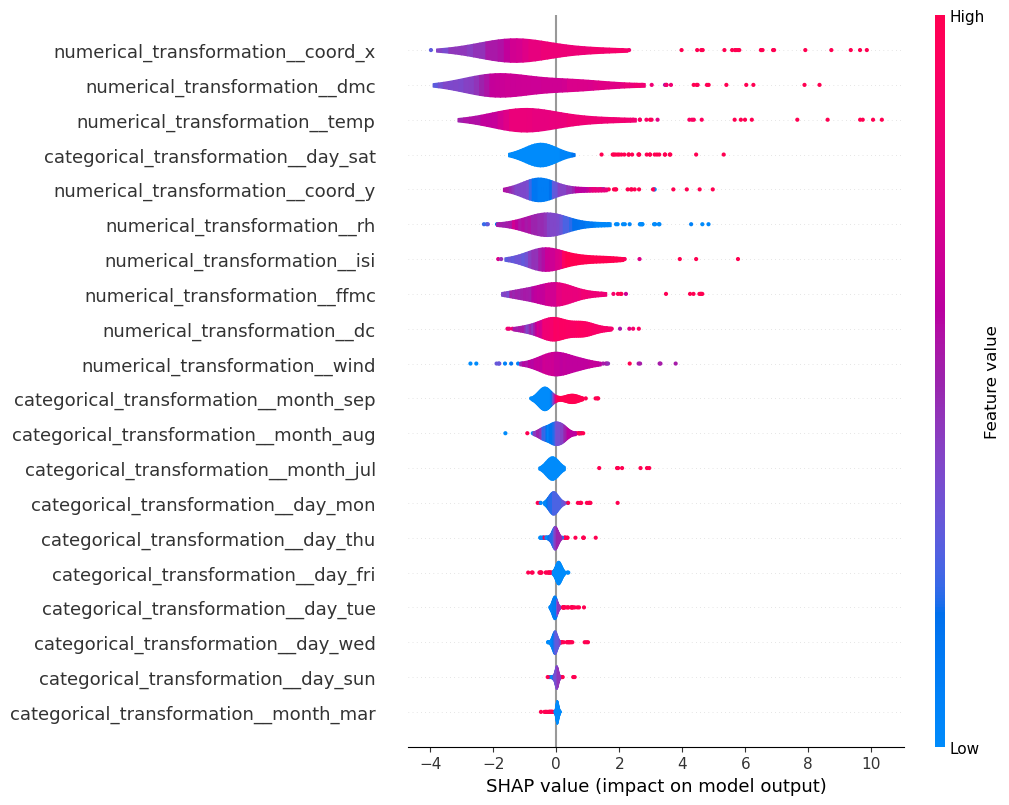

In [22]:
# Force plot for a specific instance
shap.initjs()  # Initialize JavaScript visualizshap.initjs()
shap.violin_plot(shap_values, X_test_transformed_df)

In [23]:
# Find the most important features based on SHAP values
feature_importance = np.abs(shap_values).mean(axis=0)
important_features = pd.DataFrame({
    'Feature': X_test_transformed_df.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(important_features)


                                  Feature  Importance
0       numerical_transformation__coord_x    2.044081
3           numerical_transformation__dmc    1.847720
6          numerical_transformation__temp    1.674437
24    categorical_transformation__day_sat    0.884052
1       numerical_transformation__coord_y    0.880779
7            numerical_transformation__rh    0.860522
5           numerical_transformation__isi    0.767319
2          numerical_transformation__ffmc    0.738248
4            numerical_transformation__dc    0.619984
8          numerical_transformation__wind    0.604654
21  categorical_transformation__month_sep    0.426699
11  categorical_transformation__month_aug    0.275670
15  categorical_transformation__month_jul    0.233548
23    categorical_transformation__day_mon    0.186415
26    categorical_transformation__day_thu    0.130018
22    categorical_transformation__day_fri    0.117922
27    categorical_transformation__day_tue    0.108285
28    categorical_transforma

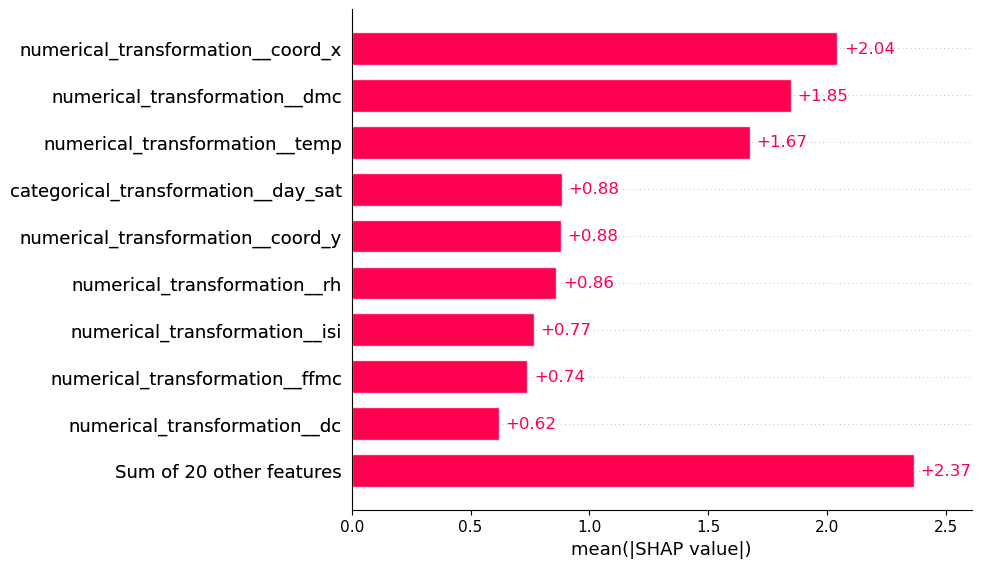

In [24]:
shap.plots.bar(explanation)

### Question answers 

Using the SHAP Waterfall plot we can infere the most important features for the particular occurence as (ordered by its impact into the occurrence descendent):



| feature | effect |
|---------|------------ |
|categorical_transformation__day_sat  | 3.45 |
|numerical_transformation__dmc  | 1.95 |
|numerical_transformation__ffmc  | -1.18 |
|numerical_transformation__coord_x  | -0.79 |


By using the bar plot (This uses the mean impact of every occurrence to clasify the importance of the features) we can find the most important features of the dataset:

| feature | importance|
|---------|-----------|
| numerical_transformation__coord_x  | 2.044081 |
| numerical_transformation__dmc  | 1.847720 |
| numerical_transformation__temp  | 1.674437 |
| categorical_transformation__day_sat  | 0.884052 |
| numerical_transformation__coord_y  | 0.880779 |
| numerical_transformation__rh  | 0.860522 |
| numerical_transformation__isi  | 0.767319 |
| numerical_transformation__ffmc  | 0.738248 |
| numerical_transformation__dc  | 0.619984 |
| numerical_transformation__wind  | 0.604654 |

And the least important features

| feature | importance|
|---------|-----------|
| categorical_transformation__month_apr | 0.007204 |
| categorical_transformation__month_may | 0.000000 |
| categorical_transformation__month_nov | 0.000000 |
| categorical_transformation__month_jan | 0.000000 |

Being said so, in order to remove a feature from the dataset I would remove the categorical data of month and day since it is in general (after transformations) the feature that less impact the model and does not have a strong correlation with the continuous features, after that it is needed to retrain the model and if possible re-run the SHAP analysis to detect how those deletions impacted the performance using the same metrics.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.